## Efficient Frontier

**Joshua and Jingwen**

The Efficient Frontier represents the set of optimal portfolios offering the highest expected return for a given level of risk. It is derived by analyzing different portfolio combinations and plotting risk (measured by standard deviation) against expected return. Any portfolio below the frontier is suboptimal, as higher returns could be achieved for the same risk level.

### Initialization

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
# Load S&P 500 prices
sp500_prices = pd.read_csv("../data/raw/tessa_sp500_prices.csv")

# # Load NCI prices
# nci_prices = pd.read_csv("../data/raw/tessa_nci_prices.csv")

# # Left join on S&P
# data = pd.merge(sp500_prices, nci_prices, on="date", how="left")
data = sp500_prices







# Make the date column the index
data = data.drop(data.columns[0], axis=1)
data.set_index("date", inplace=True)

# Calculate the percentage change for each column
for col in data.columns:
    new_col = data[col].pct_change()
    
    # If the original column has NaNs, change the corresponding new column to NaNs
    data[col] = new_col.mask(data[col].isnull(), None)
    
data

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2024-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-18,-0.009425,0.006372,0.003429,0.007595,-0.026409,-0.005224,-0.005152,0.043455,-0.020389,0.018547,...,0.006876,-0.005243,-0.002523,0.000962,0.009257,0.001729,-0.004165,0.006312,0.000385,-0.010894
2024-03-19,0.008899,0.013585,0.006555,-0.000433,0.006403,0.002954,0.014517,0.014265,-0.003556,0.010263,...,-0.003214,0.011127,0.009207,0.007494,0.007035,0.007530,0.007485,0.005557,-0.002728,0.013299
2024-03-20,-0.000746,0.014709,-0.018869,0.018048,-0.014669,0.006109,0.006242,-0.003933,0.019838,0.004588,...,0.006485,0.022589,0.003308,0.002861,-0.000884,0.002024,-0.005681,-0.001026,0.002174,-0.011390
2024-03-21,0.009913,-0.040857,0.006978,0.021067,0.000090,-0.016697,-0.093076,-0.015198,0.004271,0.018920,...,-0.000728,0.006231,-0.001199,-0.005325,0.004425,0.009945,0.000440,0.004268,0.032364,-0.015615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,-0.037885,-0.048480,0.011060,-0.016668,0.001604,-0.003077,-0.020106,-0.031865,-0.042504,0.023665,...,0.003355,-0.018923,-0.003381,0.019853,0.025500,-0.018144,-0.027318,0.024632,-0.031877,0.008394
2025-03-11,-0.007137,-0.029189,-0.014170,-0.050776,-0.034217,-0.006944,-0.022398,-0.003264,-0.033201,-0.038925,...,-0.016506,-0.016295,-0.011762,-0.008940,-0.023614,-0.036023,-0.008792,-0.029914,-0.010693,-0.043132
2025-03-12,-0.009750,-0.017479,-0.007163,0.008849,-0.017941,-0.010323,-0.010556,0.011391,-0.011766,-0.032072,...,-0.016599,-0.010480,-0.019570,0.001746,-0.000275,-0.006309,-0.014678,-0.030837,-0.004102,-0.016485


In [10]:
def portfolio_annualised_performance(weights, 
                                     mean_returns, 
                                     cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [11]:
def random_portfolios(num_portfolios:int, 
                      mean_returns, 
                      cov_matrix, 
                      risk_free_rate:float):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in tqdm.tqdm(range(num_portfolios)):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [12]:
mean_returns = data.mean()
cov_matrix = data.cov()
symbols = data.columns

num_portfolios = 25000*10
risk_free_rate = 0.0431

# Annualized
(mean_returns+1)**252 - 1

A      -0.145131
AAPL    0.284830
ABBV    0.276812
ABNB   -0.184225
ABT     0.142800
          ...   
XYL    -0.000908
YUM     0.180340
ZBH    -0.091972
ZBRA    0.017143
ZTS    -0.026361
Length: 501, dtype: float64

In [13]:
def display_simulated_ef_with_random(mean_returns,
                                     cov_matrix,
                                     num_portfolios:int,
                                     risk_free_rate:float):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=symbols,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=symbols,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print("This should be 100 or close to 100:",max_sharpe_allocation.sum(axis=1))
    print(max_sharpe_allocation)

    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    plt.show()

100%|██████████| 250000/250000 [00:34<00:00, 7200.39it/s]


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.12


This should be 100 or close to 100: allocation    99.95
dtype: float64
               A  AAPL  ABBV  ABNB   ABT  ACGL   ACN  ADBE   ADI   ADM  ...  \
allocation  0.22  0.07  0.34  0.04  0.41  0.39  0.37  0.03  0.23  0.31  ...   

             WTW    WY  WYNN   XEL   XOM   XYL   YUM   ZBH  ZBRA   ZTS  
allocation  0.07  0.26  0.02  0.05  0.21  0.22  0.36  0.06  0.36  0.01  

[1 rows x 501 columns]
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.09
Annualised Volatility: 0.12


               A  AAPL  ABBV  ABNB   ABT  ACGL   ACN  ADBE   ADI   ADM  ...  \
allocation  0.22  0.41  0.18  0.37  0.24  0.36  0.31  0.12  0.06  0.25  ...   

            WTW    WY  WYNN   XEL   XOM   XYL   YUM   ZBH  ZBRA   ZTS  
allocation  0.1

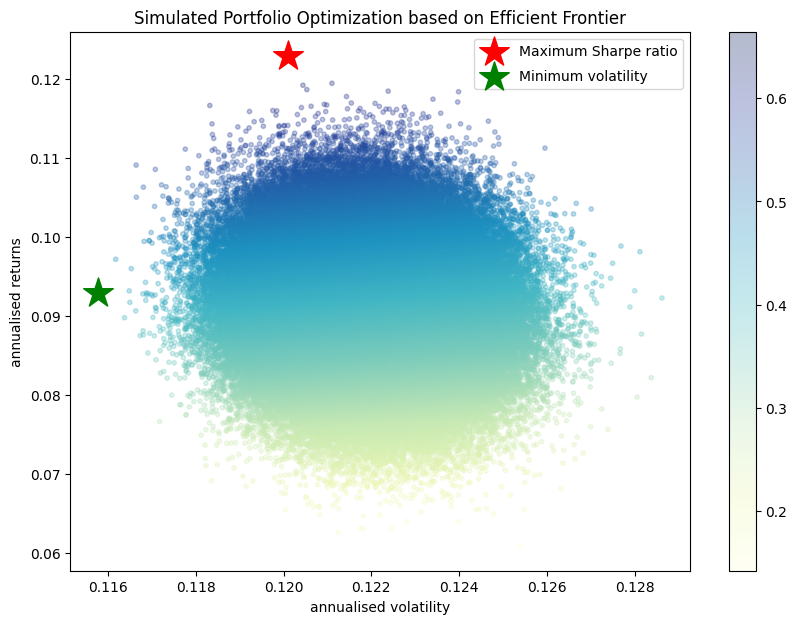

In [14]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)